In [ ]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AEP_hourly.csv to AEP_hourly.csv


In [ ]:
df = pd.read_csv('AEP_hourly.csv')
df.rename(columns={'Unnamed: 0': 'Datetime'}, inplace=True)
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

The file 'AEP_MW' is the file that needs to downloaded and used to makes sure the data is being drawn. From the column 'AEP_MW'. That colummn is a showing of the recording of hourly energy in each household. This data only contains one feature.

We load the file in and then we have to rename the first column. Since there was no name first column it is now being renamed to 'Datetime'. It now will hold the timestamps for the data table. The are real datetime **objects**. The datetime column is then set to become a index of the dataframe.

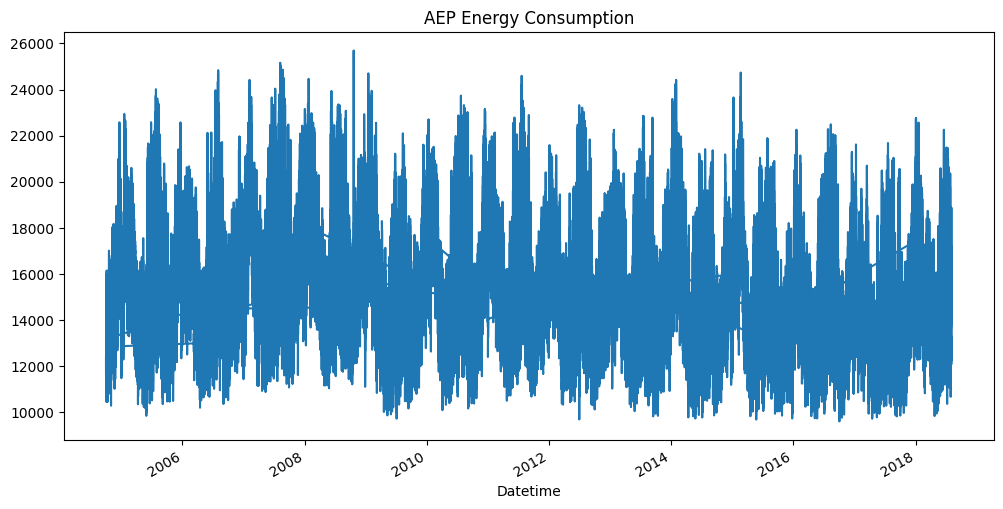

In [ ]:

df['AEP_MW'].plot(figsize=(12, 6), title='AEP Energy Consumption')
plt.show()

Here we will produce a graph that shows the Hourly Energy consumption(Y-axis) with the Years attached(X-axis). The X-axis can be changed to produce the hours instead in order to compare to the x-axis.

In [ ]:
n = len(df)
train_df = df[:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

We have a dataset called df, and what we’re trying to do is split it into three parts:

*  A training set (for teaching our model),
*  A validation set (for tuning the model),
*  A test set (for checking how good the model really is).

We take the first 70% of the rows to be our training data.
This is the data we actually use to teach the model.

We grab the next 20% for validation.
Validation is like giving the model a mini-test while it’s learning — to see if it's doing well, but without using the real final test yet

We grab the last 10% for testing.
This is where we finally ask, "Alright model, did you really learn anything?" — and we check its performance for real.


In [ ]:

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

This function creates sliding windows of data to train a model:
 It’s called create_sequences, and it takes two things:

data — a list or array of numbers

seq_length — how many numbers we want to look at in a row to predict the next number.

We grab a chunk of seq_length numbers starting at position i and add it to X.

Then, we grab the next number right after that chunk (at i + seq_length) and add it to y.

Example:
Imagine data = [2, 4, 6, 8, 10, 12] and seq_length = 3:

First pass: X = [2, 4, 6], y = 8

Second pass: X = [4, 6, 8], y = 10

Third pass: X = [6, 8, 10], y = 12


This scaler rescales all the numbers so they fit nicely between 0 and 1.
(Kind of like squeezing all your test scores onto a scale from 0 to 100 — but here, it’s 0 to 1.)



In [ ]:

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

We use fit_transform on the training data.

Fit means the scaler looks at the training data and figures out the minimum and maximum values.

Transform means it uses those min and max values to rescale all the training data between 0 and 1.

In [ ]:
sequence_length = 24
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val, y_val = create_sequences(val_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)


This means we’re going to look at 24 time steps at a time — for example, if the data is hourly, that’s one full day (24 hours).

We are creating sequences for each of our datasets:

For training, we break train_scaled into input sequences (X_train) and the next value we want to predict (y_train).

For validation, same thing for val_scaled, giving us X_val and y_val.

For testing, same thing for test_scaled, giving us X_test and y_test.

Each input (X) will be a sequence of 24 numbers, and each output (y) will be the next number after that 24.



In [ ]:

model = tf.keras.Sequential([
    layers.LSTM(256, return_sequences=True, activation='relu', input_shape=(sequence_length, train_df.shape[1])),
    layers.Dropout(0.3),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=20
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1076/4244 ━━━━━━━━━━━━━━━━━━━━ 4:30 85ms/step - loss: 0.0121 - mae: 0.0768

It’s an LSTM (Long Short-Term Memory) layer — a special type of neural network good for time series or sequence data. Dropout layer — we randomly turn off 30% of the neurons during training to help prevent overfitting (basically, so the model doesn't just memorize the training data). Final dense layer — only 1 output.

* 256 units = it has 256 memory cells (like 256 little brains).

* return_sequences=True = we tell it to return the full sequence for the next LSTM to keep working with.

* activation='relu' = adds some non-linearity (makes it able to learn more complex patterns).

* input_shape=(sequence_length, train_df.shape[1]) = the model expects inputs of 24 time steps and however many features (columns) we have in the data.

* optimizer='adam' = Adam is a really good general optimizer for neural networks.

* loss='mse' = we are minimizing Mean Squared Error (good for continuous numbers).

* metrics=['mae'] = we also track Mean Absolute Error (how wrong we are, on average).

* Train on X_train, y_train.

* Validate performance on X_val, y_val after each epoch.

* Epochs =20 = we go through the entire training set 20 times.

* Batch size= 20 = we update the model after every 20 samples.







In [ ]:

y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))


Here, we use the trained model to predict values based on X_test (our test sequences).

These predictions are still scaled between 0 and 1 — remember, we scaled the data earlier!
* inverse_transform takes the numbers back to their original range (real-world units like megawatts, dollars, temperatures, etc.).

* .reshape(-1, 1) is needed because inverse_transform expects a 2D array, not 1D.

* Same thing for the true y_test values — we unscale the real labels too.

Now both the predictions and the actual test values are in the same real-world scale, so we can compare them properly.

In [ ]:
start, end = 10000, 12000

for i in range(start, end):
    print(f"Timestep {i}: Actual = {y_test_unscaled[i][0]}, Predicted = {y_pred[i][0]}")


Now we viualize the data printing from around 2000 of those 8000 of the test data set letting the class know how to become more than what it was. Printing both the timestep (the number of hours) and the the Megawatts into graphs

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled[start:end], label='Actual', color='blue')
plt.plot(y_pred[start:end], label='Predicted', color='red')
plt.xlabel('Timestep')
plt.ylabel('AEP_MW')
plt.title('Actual vs Predicted Energy Consumption (Timesteps 10000-12000)')
plt.legend()
plt.show()

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.xlabel('Timestep')
plt.ylabel('AEP_MW')
plt.title('Actual vs Predicted Energy Consumption')
plt.legend()
plt.show()


In [ ]:
start = 10000
end = 12000

# Make sure that y_test_unscaled and y_pred contain data for these timesteps
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled[start:end], label='Actual', color='blue')
plt.plot(y_pred[start:end], label='Predicted', color='red')
plt.xlabel('Timestep')
plt.ylabel('AEP_MW')
plt.title('Actual vs Predicted Energy Consumption (Timesteps 10000-12000)')
plt.legend()
plt.show()

In [ ]:
mse_unscaled = mean_squared_error(y_test_unscaled, y_pred)
print(f"Mean Squared Error (Unscaled Data): {mse_unscaled}")